In [4]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd

In [5]:
tqdm.pandas()
news_archive_df = pd.read_csv('../data/newsarchive-bodies.csv.gz', compression='gzip', index_col=0)
nana_bodies_df = pd.read_csv(
    '../data/big-processed-nana-file-bodies-0.csv.gz', compression='gzip', index_col=0, usecols=['release_suid', 'processed_release_body']
)
nana_index_df = pd.read_csv('../data/big-processed-nana-file-0.csv.gz', compression='gzip', index_col=0)
news_archive_df = (
    news_archive_df
        .assign(processed_body= lambda df:
            df['body'].progress_apply(lambda x: BeautifulSoup(x).get_text(separator=' ')).str.strip()
        )
        .drop(columns='body')
)
nana_index_df = (
    nana_index_df
        .reset_index(drop=True)
        .sort_values('story_toa')
        .pipe(lambda df:
              df.assign(version_number=
                lambda df: df.groupby('release_suid')['story_suid'].transform('rank', method='first')
                )
              )
        .sort_index()
 )

full_df = (
    nana_index_df
        .merge(nana_bodies_df, right_index=True, left_on='release_suid')
        .merge(news_archive_df.drop(columns=['story_suid']), left_on='story_suid', right_on='suid')
        .rename(columns={'processed_body': 'processed_story_body'})
        .drop(columns='suid')
)

100%|██████████| 19484/19484 [01:01<00:00, 316.50it/s]


In [6]:
# open questions
# 1. similarity to press release, by version number
# 2. # of bullet stories, by version number
# 3. How well does BBGPT learn to summarize the bullets in an automated story?

# Basic Data Analysis

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

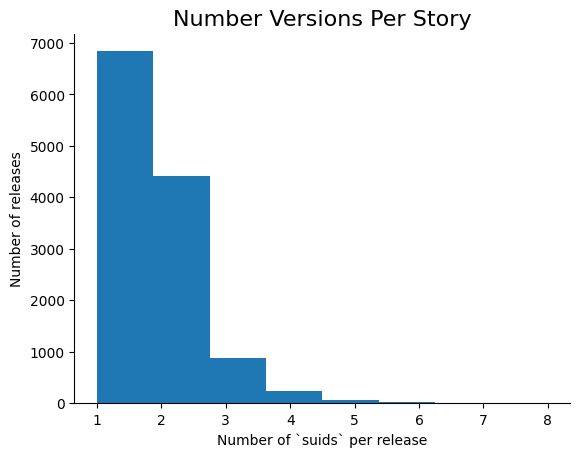

In [292]:
ax = nana_index_df['release_suid'].value_counts().hist(bins=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_ylabel('Number of releases')
ax.set_xlabel('Number of `suids` per release')
plt.title('Number Versions Per Story', fontsize=16);

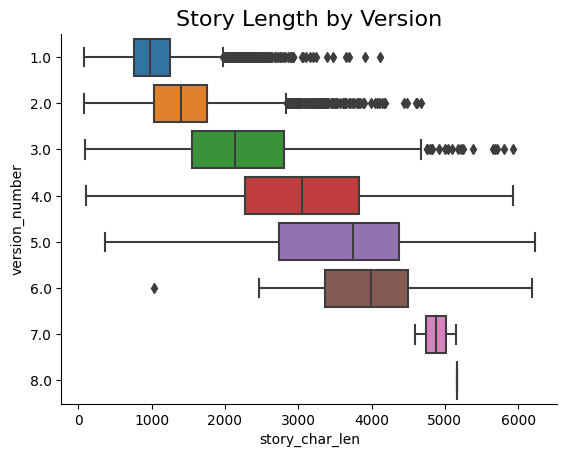

In [293]:
ax = (full_df
    .assign(story_char_len=lambda df: df['processed_story_body'].str.len())
    .assign(version_number=lambda df: df['version_number'].astype(str))
    .pipe(lambda df: sns.boxplot(data=df, y='version_number', x='story_char_len'))
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Story Length by Version', fontsize=16);

# Look at How Bloomberg Automation is Involved

In [8]:
from more_itertools import flatten

In [9]:
t = full_df.loc[lambda df: df['version_number'] == 1].iloc[1]['processed_story_body']
t.split('\n')

['Granges Makes Inventory Writedown; FY22 Effect of SEK80m ',
 ' By  Christopher Jungstedt (Bloomberg) -- ',
 ' Granges will make a non-cash inventory writedown relating to raw materials imported by Granges Americas in the first three quarters of 2022. Writedown will affect FY22 adjusted operating profit negatively by about SEK80m Amount stated is preliminary and unaudited NOTE Granges AB fell 0.1% to SEK91.35 as of 2:24 p.m. Stockholm time The average 12-month price target of SEK99.00 is 8.4% above the current price 4 buys, 1 sells, 1 holds To view the source of this information, click  here ',
 ' This story was produced with the assistance of  Bloomberg Automation . ',
 ' To contact the reporter on this story: Christopher Jungstedt  in  Stockholm  at  cjungstedt@bloomberg.net To contact the editors responsible for this story: Veronica Ek  at  vek@bloomberg.net Jonas Cho Walsgard ',
 ' Attribution Christopher Jungstedt : by reporter Jonas Cho Walsgard : editor primary Veronica Ek : ed

In [10]:
ba_lines = (
    full_df
        ['processed_story_body']
        .apply(lambda x: list(filter(lambda y: 'Bloomberg Automation' in y and 'By' not in y, x.split('\n'))))
)

In [11]:
print('How many stories mention "Bloomberg Automation"?')
print(ba_lines.str.len().value_counts().to_dict())

How many stories mention "Bloomberg Automation"?
{1: 19430, 0: 87}


In [306]:
# assumption about "automation": text in the story was generated
# reality: applied liberally to be conservative
#          how consistent is this?
#
#          todo: check if you're excluding BN systematically
#          tools help tag some things, sometime, and that includes BA. These are just BFW
#          if long-feature BN stories don't get linked to the press release, then they won't get picked up
#          double check with Andrew about when stories do and don't get linked to a press release
#          if longer-form writers update the story, there's an option to do "BN update"


print('How do they mention "Bloomberg Automation"?')
(
    ba_lines
        .pipe(lambda s: pd.Series(list(flatten(s.tolist()))))
        .str.strip()
        .value_counts()
 )

How do they mention "Bloomberg Automation"?


This story was produced with the assistance of  Bloomberg Automation .    12217
This story was produced by  Bloomberg Automation .                         6324
This headline was produced by  Bloomberg Automation .                       889
Name: count, dtype: int64

In [305]:
(full_df['processed_story_body']
                .apply(lambda x: list(filter(lambda y: 'Bloomberg Automation' in y and 'By' not in y, x.split('\n'))))
                .str.get(0).str.strip()
                # .map(ba_map)
            )

0         This story was produced by  Bloomberg Automat...
1         This story was produced with the assistance o...
2         This story was produced with the assistance o...
3         This story was produced by  Bloomberg Automat...
4         This story was produced with the assistance o...
                               ...                        
19512     This story was produced with the assistance o...
19513     This story was produced by  Bloomberg Automat...
19514     This story was produced with the assistance o...
19515     This story was produced with the assistance o...
19516     This story was produced with the assistance o...
Name: processed_story_body, Length: 19517, dtype: object

In [50]:
ba_map = {
    'This story was produced with the assistance of Bloomberg Automation.': False,
    'This story was produced by Bloomberg Automation.': True,
    'This headline was produced by Bloomberg Automation.': False
}
ba_map_with_spaces = {
    'This story was produced with the assistance of  Bloomberg Automation .': False,
    'This story was produced by  Bloomberg Automation .': True,
    'This headline was produced by  Bloomberg Automation .': False,
}

full_df['entirely_bloomberg_automated'] = (full_df['processed_story_body']
                .apply(lambda x: list(filter(lambda y: 'Bloomberg Automation' in y and 'By' not in y, x.split('\n'))))
                .str.get(0).str.strip()
                .map(ba_map_with_spaces)
            )
full_df.groupby('version_number')['entirely_bloomberg_automated'].mean()
    # .assign(version_number=lambda df: df['version_number'].astype(str))
    # .pipe(lambda df: sns.violinplot(data=df, y='version_number', x='entirely_bloomberg_automated'))

version_number
1.0    0.473091
2.0    0.099464
3.0    0.014803
4.0         0.0
5.0         0.0
6.0         0.0
7.0         0.0
8.0         0.0
Name: entirely_bloomberg_automated, dtype: object

# Lexical Differences Between Press Release and Article

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.spatial.distance import jensenshannon

In [313]:
cv = TfidfVectorizer(min_df=.001, max_df=.5, stop_words='english')

In [314]:
cv.fit(full_df.pipe(lambda df:
             pd.concat([
                 df['processed_release_body'].drop_duplicates(),
                 df['processed_story_body'].drop_duplicates()
             ]).dropna()
             ))

TfidfVectorizer(max_df=0.5, min_df=0.001, stop_words='english')

In [141]:
release_vecs = cv.transform(full_df['processed_release_body'].fillna(''))
story_vecs = cv.transform(full_df['processed_story_body'].fillna(''))

### cosine similarity

In [142]:
from  sklearn.metrics.pairwise import cosine_similarity

In [151]:
all_cos = []
for r_v, s_v in tqdm(zip(release_vecs, story_vecs)):
    cos = cosine_similarity(r_v, s_v)
    all_cos.append(float(cos))

19517it [00:17, 1107.27it/s]


In [152]:
full_df['cosine (release || story)'] = all_cos

<Axes: xlabel='cosine (release || story)', ylabel='version'>

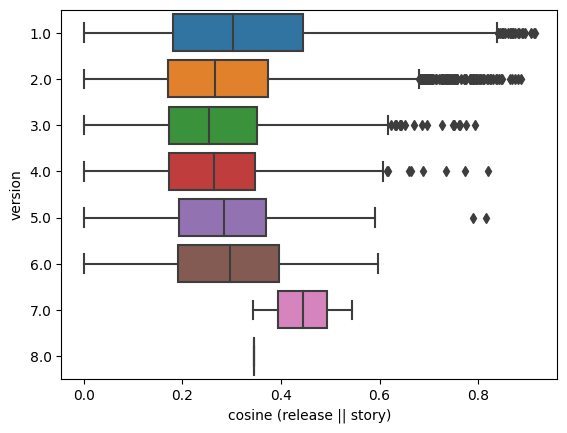

In [155]:
(full_df
 .assign(version=lambda df: df['version_number'].astype(str))
 .pipe(lambda df: sns.boxplot(data=df, x='cosine (release || story)', y='version'))
 )

# Look at First and Last Drafts of Stories

In [74]:
full_df = (
    full_df
        .assign(
        entirely_bloomberg_automated=lambda df:
            df['processed_story_body']
                .apply(lambda x: list(filter(lambda y: 'Bloomberg Automation' in y and 'By' not in y, x.split('\n'))))
                .str.get(0).str.strip()
                .map(ba_map_with_spaces)
            )
 )

In [75]:
first_drafts = full_df.loc[lambda df: df['version_number'] == 1]
last_drafts = (
    full_df
        .groupby('release_suid').apply(lambda df: df.sort_values('version_number').iloc[-1])
        .loc[lambda df: df['version_number'] != 1]
)

In [76]:
first_drafts['wire_mnemonic'].value_counts()

wire_mnemonic
BFW    11770
BN       446
Name: count, dtype: int64

In [77]:
last_drafts['wire_mnemonic'].value_counts()

wire_mnemonic
BFW    5189
BN      413
Name: count, dtype: int64

In [78]:
last_drafts.iloc[0]

story_suid                                                           RNSL3K6RV5DS
release_suid                                                         RNSHVOMEQTXC
release_bundle_id                                                    RNSHVOMEQTXC
release_id                                                                2526047
story_type                                                                   FILL
release_type                                                                Story
story_toa                                        2023-01-01 05:40:33.240000+00:00
release_toa                                             2023-01-01 04:31:00+00:00
story_headline                  CORRECT: XPeng Dec. Vehicle Deliveries 11,292 ...
story_wire                                                                   2345
story_wire_class                                                                3
release_wire                                                                   39
release_wire_cla

In [79]:
col_order = [
    'release_suid', 'release_toa', 'first_version_story_toa', 'last_version_story_toa',
    'entirely_bloomberg_automated_x', 'entirely_bloomberg_automated_y',
    'release_subject', 'first_version_story_headline', 'last_version_story_headline',
    'processed_release_body', 'first_version_processed_story_body',
    'last_version_processed_story_body',
]

first_last_draft_df = (
    first_drafts
    [[
        'release_suid',
        'release_toa',
        'story_toa',
        'story_headline',
        'entirely_bloomberg_automated',
        'release_subject',
        'processed_story_body',
        'processed_release_body'
    ]]
    .rename(columns=lambda x: 'first_version_' + x if 'story' in x else x)
    .merge(
        last_drafts[[
            'story_toa',
            'entirely_bloomberg_automated',
            'story_headline',
            'processed_story_body',
        ]].rename(columns=lambda x: 'last_version_' + x if 'story' in x else x),
        left_on='release_suid',
        right_index=True
    )
)[col_order]

In [35]:
import sys
from IPython.display import display, HTML
sys.path.insert(0, '../../../usc-research/edit-pathways/util/')
import util_newssniffer_parsing as unp
import pprint as pp
pp = pp.PrettyPrinter(indent=4)
def print_packet(idx, t_df=None, comparison_type='story'):
    if comparison_type == 'story':
        first_hed, second_hed = 'first_version_story_headline', 'last_version_story_headline'
        first_body, second_body = 'first_version_processed_story_body', 'last_version_processed_story_body'
        first_toa, second_toa = 'first_version_story_toa', 'last_version_story_toa'
    else:
        first_hed, second_hed = 'release_subject', 'last_version_story_headline'
        first_body, second_body = 'processed_release_body', 'last_version_processed_story_body'
        first_toa, second_toa = 'release_toa', 'last_version_story_toa'

    html_headline_first, html_headline_last = unp.html_compare_sentences(
        t_df.iloc[idx][first_hed],
        t_df.iloc[idx][second_hed]
    )
    html_story_first, html_story_last = unp.html_compare_sentences(
        t_df.iloc[idx][first_body],
        t_df.iloc[idx][second_body]
    )
    pp.pprint(
        t_df
            .iloc[idx][[first_toa, second_toa]]
            .to_dict()
    )

    print('headlines:')
    print('\n')
    display(HTML(html_headline_first.replace('\n', '<br>')))
    display(HTML(html_headline_last.replace('\n', '<br>')))

    print('stories: ')
    print('\n')
    display(HTML(html_story_first.replace('\n', '<br>')))
    display(HTML(html_story_last.replace('\n', '<br>')))

In [80]:
t_df = first_last_draft_df.loc[lambda df: df['entirely_bloomberg_automated_y'] == False]

In [81]:
t = print_packet(2, t_df)

{   'first_version_story_toa': '2023-02-09 07:00:40.188000+00:00',
    'last_version_story_toa': '2023-02-09 07:09:44.730000+00:00'}
headlines:




stories: 




# Look at pairs of release/ Last drafts

In [82]:
# print_packet(1, t_df, comparison_type='release')

In [143]:
example = t_df[[
    'release_toa',
    'release_subject',
    'last_version_story_headline',
    'processed_release_body',
    'last_version_processed_story_body'
]].iloc[1]

In [148]:
t_df.iloc[1]

release_suid                                                               RP2Y26C6HM2Q
release_toa                                                   2023-01-26 06:30:06+00:00
first_version_story_toa                                2023-01-26 06:30:10.656000+00:00
last_version_story_toa                                 2023-01-26 06:33:51.154000+00:00
entirely_bloomberg_automated_x                                                     True
entirely_bloomberg_automated_y                                                    False
release_subject                          Gränges’ year-end report January–December 2022
first_version_story_headline          Granges 4Q Adjusted Operating Profit Misses Es...
last_version_story_headline           Granges 4Q Adjusted Operating Profit Misses Es...
processed_release_body                A stable fourth quarter concluded a record yea...
first_version_processed_story_body    Granges 4Q Adjusted Operating Profit Misses Es...
last_version_processed_story_bod

In [153]:
print(example['processed_release_body'])

A stable fourth quarter concluded a record year


Fourth quarter 2022

Sales volume decreased by 1.8 per cent to 110.3 ktonnes (112.3) and net sales increased to SEK 5,366 million (4,857).
Adjusted operating profit increased to SEK 153 million (139) and adjusted operating profit per tonne amounted to 1.4 kSEK (1.2).
Operating profit amounted to SEK 153 million (-21) and includes no items affecting comparability (-159).
Profit for the period increased to SEK 51 million (-23).
Diluted earnings per share increased to SEK 0.48 (-0.21).
Cash flow before financing activities adjusted for expansion investments and acquisitions was SEK 679 million (463).
Revolving credit facility and term loans refinanced with sustainability-linked structure.
Total carbon emissions intensity (scope 1+2+3) decreased to 8.8 tonnes CO2e/tonne (9.3).
The share of sourced recycled aluminium increased to 33.5 per cent (32.9).
Dual Aluminium Stewardship Initiative sustainability certifications achieved for Granges Am

# Explore Bloomberg GPT on text of press releases

In [85]:
import requests
import json
import os
os.environ['CURL_CA_BUNDLE'] = '/Users/alex/.bb-cert/ca-bundle.trust.crt'

In [161]:
example_release_body = example['processed_release_body'].split('\n\n\n')#[:-5]
example_release_body = '\n\n'.join(example_release_body)

In [162]:
example

release_toa                                                  2023-01-26 06:30:06+00:00
release_subject                         Gränges’ year-end report January–December 2022
last_version_story_headline          Granges 4Q Adjusted Operating Profit Misses Es...
processed_release_body               A stable fourth quarter concluded a record yea...
last_version_processed_story_body    Granges 4Q Adjusted Operating Profit Misses Es...
Name: 3, dtype: object

In [190]:
def format_summarize_press_release_prompt(input_text):
    return f"""
    {input_text}

    Below is a bullet-point summary of the above article:
    """

def format_instructions(input_text):
    input_text = input_text.replace('\n' ,' ')
    return f"""
    You are a journalist. Please summarize the important points in the following press release.
    Do not say anything not in the press release.

    Here is the press release: "{input_text}". Write you summarized bullet points now:
    """

In [200]:
model_url = 'https://bbgpt-dev-s-ailm.inference-dev-01-pw.dsp.dev.bloomberg.com/v1/models/bbgpt:predict'
instruct_model_a_url = 'https://bbgpt-ft-a-dev-s-ailm.inference-dev-01-tt.dsp.dev.bloomberg.com/v1/models/bbgpt-ft-a:predict'
instruct_model_b_url = 'https://bbgpt-ft-b-dev-s-ailm.inference-dev-01-tt.dsp.dev.bloomberg.com/v1/models/bbgpt-ft-b:predict'
# model_url = 'https://mpt-7b-instruct-s-ailm.inference-dev-01-tt.dsp.dev.bloomberg.com/v1/models/mpt-7b-instruct:predict'
data = {
    "instances": [
        {
            "context": format_instructions(example_release_body),
            "temperature": .5,
            "repetition_penalty": 1,
            "num_beams": 5,
        }
    ]
}
r = requests.post(instruct_model_b_url, data=json.dumps(data))
out = json.loads(r.text)


In [201]:
print(out["predictions"][0]["output"])

 - Sales volume amounted to 479.3 (488.9) ktonnes, and net sales increased to SEK 24,492 million (18,130).    - Adjusted operating profit increased to SEK 1,150 million (1,008) and adjusted operating profit per tonne amounted to 2.4 kSEK (2.1).    - Operating profit was SEK 1,136 million (833) and includes items affecting comparability of SEK -14 million (-175).    - 


In [152]:
print(example['processed_release_body'])

A stable fourth quarter concluded a record year


Fourth quarter 2022

Sales volume decreased by 1.8 per cent to 110.3 ktonnes (112.3) and net sales increased to SEK 5,366 million (4,857).
Adjusted operating profit increased to SEK 153 million (139) and adjusted operating profit per tonne amounted to 1.4 kSEK (1.2).
Operating profit amounted to SEK 153 million (-21) and includes no items affecting comparability (-159).
Profit for the period increased to SEK 51 million (-23).
Diluted earnings per share increased to SEK 0.48 (-0.21).
Cash flow before financing activities adjusted for expansion investments and acquisitions was SEK 679 million (463).
Revolving credit facility and term loans refinanced with sustainability-linked structure.
Total carbon emissions intensity (scope 1+2+3) decreased to 8.8 tonnes CO2e/tonne (9.3).
The share of sourced recycled aluminium increased to 33.5 per cent (32.9).
Dual Aluminium Stewardship Initiative sustainability certifications achieved for Granges Am

In [95]:
print(example['last_version_processed_story_body'])

Avanza 4Q Operating Income Beats Estimates 
 By  Anton Wilen  and  Bloomberg Automation (Bloomberg) -- 
 Avanza reported operating income for the fourth quarter that beat the average analyst estimate. FOURTH QUARTER RESULTS Operating income SEK847 million, +2.8% y/y, estimate SEK819 million ( Bloomberg Consensus ) Net income SEK494 million, estimate SEK436.9 million Net outflows SEK7.45 billion vs. inflows SEK17.90 billion y/y 2022 YEAR RESULTS Dividend per share SEK7.50, estimate SEK7.28 YEAR FORECAST Sees total costs SEK1.16 billion COMMENTARY AND CONTEXT Costs for the full-year amounted to SEK1,031 million. This is lower than the previously estimated range and is mainly due to lower personnel costs, but also slightly lower costs for IT  NOTE For Bloomberg Consensus estimates used in this story see:  AZA SS Equity MODL 1 buy, 5 holds, 7 sells Call 10 a.m. Stockholm time, +448081751536 password: 443847 Conference call website Statement : "Avanza Bank Holding AB (publ): Preliminary Fin